# Two-layer Neural Network Workbook for CS145 Homework 3

----
<span style="color:red">**PRINT YOUR NAME AND UID HERE!**</span>

NAME: [Anisetti, Rajiv] UID: [904801422]

----


Please follow the notebook linearly to implement a two layer neural network.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a two layer neural network.

---

Import libraries and define relative error function, which is used to check results later. 

In [1]:
import random
import numpy as np
from cs145.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Toy example

Before loading CIFAR-10, there will be a toy example to test your implementation of the forward and backward pass.

In [4]:
from lib.neural_net import TwoLayerNet

In [5]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Compute forward pass scores

In [6]:
## Implement the forward pass of the neural network.

# Note, there is a statement if y is None: return scores, which is why 
# the following call will calculate the scores.
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-1.07260209,  0.05083871, -0.87253915],
    [-2.02778743, -0.10832494, -1.52641362],
    [-0.74225908,  0.15259725, -0.39578548],
    [-0.38172726,  0.10835902, -0.17328274],
    [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

Difference between your scores and correct scores:
3.381231210991542e-08


### Forward pass loss

The total loss includes data loss (MSE) and regularization loss, which is,

$$L = L_{data}+L_{reg} = \frac{1}{2N}\sum_{i=1}^{N}\left(\boldsymbol{y}_{\text{pred}}-\boldsymbol{y}_{\text{target}}\right)^2 + \frac{\lambda}{2} \left(||W_1||^2 + ||W_2||^2 \right)$$

More specifically in multi-class situation, if the output of neural nets from one sample is $y_{\text{pred}}=(0.1,0.1,0.8)$ and $y_{\text{target}}=(0,0,1)$ from the given label, then the MSE error will be $Error=(0.1-0)^2+(0.1-0)^2+(0.8-1)^2=0.06$

Implement data loss and regularization loss. In the MSE function, you also need to return the gradients which need to be passed backward. This is similar to batch gradient in linear regression. Test your implementation of loss functions. The Difference should be less than 1e-12.

In [16]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss_MSE = 1.8973332763705641 # check this number

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss_MSE)))

Difference between your loss and correct loss:
0.0


### Backward pass (You do not need to implemented this part)

We have already implemented the backwards pass of the neural network for you.  Run the block of code to check your gradients with the gradient check utilities provided. The results should be automatically correct (tiny relative error).

If there is a gradient error larger than 1e-8, the training for neural networks later will be negatively affected.

In [17]:
from cs145.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 8.800911222099066e-11
b2 max relative error: 2.4554844805570154e-11
W1 max relative error: 1.7476665046687833e-09
b1 max relative error: 7.382451041178829e-10


### Training the network

Implement neural_net.train() to train the network via stochastic gradient descent, much like the linear regression.

Final training loss:  0.02950555626206818


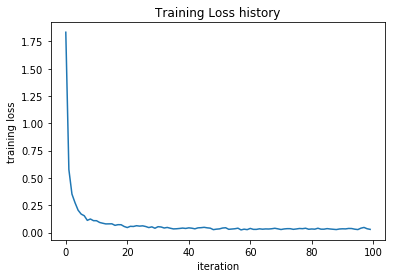

In [18]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR-10

Do classification on the CIFAR-10 dataset.

In [19]:
from cs145.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = './cs145/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Running SGD

If your implementation is correct, you should see a validation accuracy of around 15-18%.

In [20]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
net = init_toy_model()
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-5, learning_rate_decay=0.95,
            reg=0.1, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Save this net as the variable subopt_net for later comparison.
subopt_net = net

iteration 0 / 1000: loss 0.5000623457905098
iteration 100 / 1000: loss 0.4998246529435278
iteration 200 / 1000: loss 0.4995946718475304
iteration 300 / 1000: loss 0.49933536166627984
iteration 400 / 1000: loss 0.4989962372581251
iteration 500 / 1000: loss 0.49847178744773624
iteration 600 / 1000: loss 0.49758927830530253
iteration 700 / 1000: loss 0.4966248113033766
iteration 800 / 1000: loss 0.4958001901438695
iteration 900 / 1000: loss 0.4939583435911163
Validation accuracy:  0.172


In [21]:
stats['train_acc_history']

[0.09, 0.15, 0.225, 0.195, 0.225]

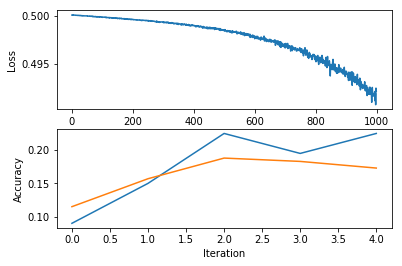

In [22]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.show()

### Questions:

The training accuracy isn't great. It seems even worse than simple KNN model, which is not as good as expected.

(1) What are some of the reasons why this is the case?  Take the following cell to do some analyses and then report your answers in the cell following the one below.

(2) How should you fix the problems you identified in (1)?

### Answers:

(1) We have not properly tuned our neural network. We have only tried a single subset of the infinite possibilities of combinations of hyperparameters. There are many more possibilities that may lead to higher validation accuracies. In addition, this is only a two-layer neural network, so it is not as rigorous as may be necessary for such a complex data set such as animals. 

(2) With proper tuning, we may be able to increase our validation accuracy by finding the correct set of hyperparameters. In addition, we could also increase the validation accuracy by perhaps increase the number of hidden layers, making us have a more complex and accurate neural network.



## Optimize the neural network

Use the following part of the Jupyter notebook to optimize your hyperparameters on the validation set.  Store your nets as best_net.

In [33]:
best_net = None # store the best model into this 

# ================================================================ #
# YOUR CODE HERE:
#   Optimize over your hyperparameters to arrive at the best neural
#   network.  You should be able to get over 45% validation accuracy.
#   For this part of the notebook, we will give credit based on the
#   accuracy you get.  Your score on this question will be multiplied by:
#      min(floor((X - 23%)) / %22, 1) 
#   where if you get 50% or higher validation accuracy, you get full
#   points.
#
#   Note, you need to use the same network structure (keep hidden_size = 50)!
# ================================================================ #

# todo: optimal parameter search (you can use grid search by for-loops )

input_size = 32 * 32 * 3 # do not change
hidden_size = 50 # do not change
num_classes = 10 # do not change
best_valacc = 0 # do not change

# Train the network and find best parameter: 

optimal_settings = ''
learning_rates = [1e-4, 1e-3]
decays = [0.8, 0.75, 0.6]
regularizations = [1, 2, 4]

for lr in learning_rates:
    for d in decays:
        for regz in regularizations:
            stats = net.train(X_train, y_train, X_val, y_val, num_iters=1000, batch_size=500, learning_rate=lr, learning_rate_decay=d, reg=regz, verbose=True)
            val_acc = (net.predict(X_val) == y_val).mean()
            print('Validation accuracy: ', val_acc)
            print('learning_rate: {}, iterations: {}, batch_sizes: {}, lrdecay: {}, regularization: {}'.format(lr, 1000, 500, d, regz))
            if val_acc > best_valacc:
                best_valacc = val_acc
                best_net = net
                optimal_settings = 'learning_rate: {}, iterations: {}, batch_sizes: {}, lrdecay: {}, regularization: {}'.format(lr, 1000, 500, d, regz)
                        

# Output your results
print("== Best parameter settings ==")
print(optimal_settings)
print("Best accuracy on validation set: {}".format(best_valacc))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

iteration 0 / 1000: loss 0.4707053578994485
iteration 100 / 1000: loss 0.453558022225583
iteration 200 / 1000: loss 0.44429485447466344
iteration 300 / 1000: loss 0.43834460125541624
iteration 400 / 1000: loss 0.4373454154462407
iteration 500 / 1000: loss 0.43139539537264004
iteration 600 / 1000: loss 0.4358588820793203
iteration 700 / 1000: loss 0.4303847260818199
iteration 800 / 1000: loss 0.4277158254124888
iteration 900 / 1000: loss 0.4233589750216512
Validation accuracy:  0.277
learning_rate: 0.0001, iterations: 1000, batch_sizes: 500, lrdecay: 0.8, regularization: 1
iteration 0 / 1000: loss 0.43421452082865464
iteration 100 / 1000: loss 0.42560854112846186
iteration 200 / 1000: loss 0.4213644216220823
iteration 300 / 1000: loss 0.42441302064457465
iteration 400 / 1000: loss 0.4146334397995836
iteration 500 / 1000: loss 0.41982300749524293
iteration 600 / 1000: loss 0.41997039507282585
iteration 700 / 1000: loss 0.4127416502204362
iteration 800 / 1000: loss 0.41202789372502774
ite

iteration 200 / 1000: loss 0.39378882728602216
iteration 300 / 1000: loss 0.39442301994659124
iteration 400 / 1000: loss 0.38041269101094705
iteration 500 / 1000: loss 0.38389277447364206
iteration 600 / 1000: loss 0.3870944785362808
iteration 700 / 1000: loss 0.38118376915971197
iteration 800 / 1000: loss 0.38475811062525966
iteration 900 / 1000: loss 0.3879065223240719
Validation accuracy:  0.48
learning_rate: 0.001, iterations: 1000, batch_sizes: 500, lrdecay: 0.75, regularization: 4
iteration 0 / 1000: loss 0.35569010052346667
iteration 100 / 1000: loss 0.37399027359647014
iteration 200 / 1000: loss 0.3598165084744659
iteration 300 / 1000: loss 0.35805200362703177
iteration 400 / 1000: loss 0.355848896301527
iteration 500 / 1000: loss 0.35133996666179174
iteration 600 / 1000: loss 0.3549076869336756
iteration 700 / 1000: loss 0.3645371424579957
iteration 800 / 1000: loss 0.37371990350928996
iteration 900 / 1000: loss 0.3562798237010549
Validation accuracy:  0.491
learning_rate: 0.0

### Quesions

(1) What is your best parameter settings? (Output from the previous cell)

(2) What parameters did you tune? How are they changing the performance of nerural network? You can discuss any observations from the optimization.

### Answers

(1)

My best parameter settings are: 

learning_rate: 0.001, iterations: 1000, batch_sizes: 500, lrdecay: 0.6, regularization: 1


(2)

At first, I decided to tune all of the parameters with nested for loops. However, the runtime of this tuning process ended up being extremely long. Instead, I looked at the results that had printed out throughout this process and noticed that the most noticeable changes occurred from changing the learning rate, learning rate decay, and regularization. I then further tuned this parameters to a subset of values that are shown in the code. The tuning of these parameters quickly changed my validation accuracy to .45+, and allowed me to get the best set of parameters shown above.

## Visualize the weights of your neural networks

/Users/rajivanisetti/Downloads/HW3/.env/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/rajivanisetti/Downloads/HW3/.env/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


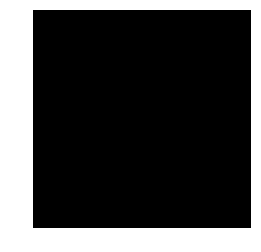

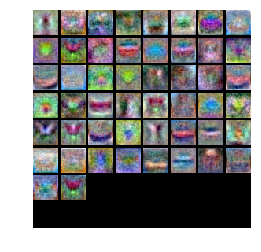

In [39]:
from cs145.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.T.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(subopt_net)
show_net_weights(best_net)

### Questions:

What differences do you see in the weights between the suboptimal net and the best net you arrived at? What do the weights in neural networks probably learn after training?

### Answer:

The weights of the best neural net seem far less noisy and more distinct/fine-tuned than the previous one. It seems that the neural network was able to finally distinguish between different the different attributes in the CIFAR dataset, and can make much more accurate and fine-tuned predictions than before.

---

## Evaluate on test set 

In [36]:
test_acc = (best_net.predict(X_test) == y_test).mean()
#test_acc = (subopt_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.464


### Questions:
(1) What is your test accuracy by using the best NN you have got? How much does the performance increase compared with kNN? Why can neural networks perform better than kNN?

(2) Do you have any other ideas or suggestions to further improve the performance of neural networks other than the parameters you have tried in the homework? 

### Answers:

(1)

The best accuracy I got from my optimal neural network was 46.4%. This is much better than our kNN implementation, which only had an accuracy of about 28%. Neural networks perform better than kNN here because of its sophisticated learning/training process. With multiple hidden layers and activation functions, the neural network can make distinctions at a much finer granularity, while kNN can only rely on distances between attributes. Thus, the neural network's advantage is due to its complexity and rigorous training/prediction process.

(2)

As I stated before, if we were able to add more hidden layers, we may be able to make an even more accurate neural network. The addition of hidden layers allows the neural network to learn more sophisticated features from the previous layers, which could prove quite useful when trying to make distinguishing between the CIFAR objects.

---

## Bonus Question: Change MSE Loss to Cross Entropy Loss

This is a bonus question. If you finish this (cross entropy loss) correctly, you will get **up to 20 points** (add up to your HW3 score). 

Note: From grading policy of this course, your maximum points from homework are still 25 out of 100, but you can use the bonus question to make up other deduction of other assignments.

Pass output scores in networks from forward pass into softmax function. The softmax function is defined as,
$$p_j = \sigma(z_j) = \frac{e^{z_j}}{\sum_{c=1}^{C} e^{z_c}}$$
After softmax, the scores can be considered as probability of $j$-th class.

The cross entropy loss is defined as,
$$L = L_{\text{CE}}+L_{reg} = \frac{1}{N}\sum_{i=1}^{N} \log \left(p_{i,j}\right)+ \frac{\lambda}{2} \left(||W_1||^2 + ||W_2||^2 \right)$$

To take derivative of this loss, you will get the gradient as,
$$\frac{\partial L_{\text{CE}}}{\partial o_i} = p_i - y_i $$

More details about multi-class cross entropy loss, please check [http://cs231n.github.io/linear-classify/](http://cs231n.github.io/linear-classify/) and [more explanation](https://deepnotes.io/softmax-crossentropy) about the derivative of cross entropy.

Change the loss from MSE to cross entropy, you only need to change you ```MSE_loss(x,y)``` in ```TwoLayerNet.loss()``` function to ```softmax_loss(x,y)```.

**Now you are free to use any code to show your results of the two-layer networks with newly-implemented cross entropy loss. You can use code from previous cells.**

In [ ]:
# Start training your networks and show your results